# Run Q3Dfit from this Jupyter Notebook in Astroconda Environment.

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://wwwstaff.ari.uni-heidelberg.de/dwylezalek/q3d.html) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.1. Setting up the directory tree](#chapter1_1)
    * [1.2. Setting up the fitting parameters](#chapter1_2)        
        * [1.2.3. Line ratio constraints](#chapter1_2_3)
    * [1.3. Setting up the plotting parameters](#chapter1_3)        
* [2. Run Q3Dfit](#chapter2)
* [3. Run plotting script (q3da)](#chapter3)

<font color='red'>We need to decide where the makeqsotemplate functionality goes. </font>

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [3]:
import os.path
import numpy as np

### 1.1. Setting up the directory tree <a class="anchor" id="chapter1_1"></a>

Define the directories in which your data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from Q3Dfit will be saved. 

In [4]:
# book-keeping variables (optional; for this box only)
volume = '/Users/drupke/Box Sync/f05189stis/' # base directory
gal = 'f05189nuc' # prefix label for output files

# Input files
infile = volume+'f05189avg_nucleus_ap7pix.fits' # path + name of your input cube

# Output directories/files
outdir = volume+'q3dfit/nuc/' # path + name of directory for saving the output files
path_to_npy_file = outdir # path for initproc.npy
logfile = outdir+gal+'_fitlog.txt'

Some general information about your cube:

In [22]:
ncols = 1
nrows = 1
fitrange = [0.1450, 0.3300]

if not os.path.isfile(infile): print('Data cube not found.')

### 1.2. Setting up the fitting parameters <a class="anchor" id="chapter1_2"></a>

What lines do you want to fit? You can choose from the linelist <font color='red'>provide reference here</font>.

In [30]:
lines = ['MgII2796','MgII2803']

How many components do you want to be fitted to the emission lines?

In [7]:
maxncomp = 1

In [31]:
# Initialize line ties, n_comps, z_inits, and sig_inits.
linetie = dict()
ncomp = dict()
zinit_gas = dict()
siginit_gas = dict()
for i in lines:
    linetie[i] = 'MgII2796'
    ncomp[i] = np.full((ncols, nrows), 1)
    zinit_gas[i] = np.full((ncols, nrows,  maxncomp), 0.0428)
    siginit_gas[i] = np.full(maxncomp, 1000)

`siglim_gas` sets lower and upper bounds for the Gaussian width (sigma) of the emission line. These limits can be set globablly, for all spaxels and components, by defining a 2-element array. The limits can also be set for individual spaxels (but all components) by defining an (Ncol x Nrow x 2) array.

In [9]:
# Global limit
siglim_gas = np.array([5., 5000.])

Description of continuum fitting parameters

In [10]:
fcncontfit = 'fitpoly'
#argscontfit = dict()
#argscontfit['siginit_stars'] = 50

#### 1.2.3. Line ratio constraints <a class="anchor" id="chapter1_2_3"></a>
`line1`, `line2`, and `comp` are required. `value` is the initial value of `line1`/`line2`, and `lower` and `upper` limits can also be specified. (If they are not, and the line pair is a doublet in the doublets.tbl file, then the lower and upper limits are set using the data in that file.) The ratio can also be `fixed`.

In [25]:
# Required columns
line1 = ['MgII2796']
line2 = ['MgII2803']
comp = np.array([0], dtype=np.int32)

# Optional columns:
#value = []
#fixed = []
# lower = []
# upper = []

# Write table
from astropy.table import QTable
lineratio = QTable([line1, line2, comp], names=['line1', 'line2', 'comp'])

### 1.3. Setting up the plotting parameters <a class="anchor" id="chapter1_3"></a>

One dictionary must be defined for a line plot to appear. `argspltlin1` holds the options for the first line plot, and `argspltlin2` is for the second. Parameter options are fed in as keyword/data pairs.

Required keywords in each dictionary:
* `nx`: Number of subplots in the horizontal direction
* `ny`: Number of subplots in the vertical direction
* Options for centerting the plot:
    - `line`: a string list of line labels
    - `center_obs`: a float list of wavelengths of each subplot center, in the observed (plotted) frame
    - `center_rest`: a float list of wavelengths of each subplot center, in the rest frame, which are converted to obs. frame

Optional keywords:
* `size`: float list of widths in wavelength space of each subplot; if not specified, default is 300 $Å$
* `IR`: set to `True` to use infrared-style plot

In [26]:
argspltlin1 = {'nx': 1,
               'ny': 1,
               'line': ['MgII2796'],
               'size': [0.025]}

The following cell will create the initialisation structure. **Do not change anything in this cell.** 

In [103]:
initproc = { \
            # Required pars
            'fitran': fitrange,
            # first # is DIFF2PT from header, second is correction to 6 pixel aperture
            # See STIS DHB 5.4.1 and f05189_spatialprofile.ipynb
            'fluxunits': 1.*0.01607/0.925,
            'infile': infile,
            'label': gal,
            'lines': lines,
            'linetie': linetie,
            'maxncomp': maxncomp,
            'name': 'Makani',
            'ncomp': ncomp,
            'outdir': outdir,
            #'zinit_stars': zinit_stars,
            'zinit_gas': zinit_gas,
            'zsys_gas': 0.0428,
            # Optional pars
            'datext': 1,
            'varext': 2,
            'dqext': 3,
            'argscheckcomp': {'sigcut': 2},
            'fcncontfit': fcncontfit,
            #'argscontfit': argscontfit,
            'argsreadcube': {'wmapext': None,
                             'waveunit_in': 'Angstrom',
                             'fluxunit_in': 'erg/s/cm2/Angstrom/sr'},
            'argscontplot': {'xstyle':'lin',
                             'ystyle':'lin',
                             'waveunit_out': 'Angstrom',
                             'fluxunit_in':'flambda',
                             'fluxunit_out':'flambda',
                             'mode':'dark'},
            'argsinitpar': {'siglim': siglim_gas,
                            'lineratio': lineratio},
            'argslinefit': {'ftol': 1e-12, 'xtol': 1e-18},
            'argspltlin1': argspltlin1,
            'fcncheckcomp': 'checkcomp',
            'maskwidths_def': 2000,
            'emlsigcut': 2,
            'logfile': logfile,
            'siglim_gas': siglim_gas,
            'siginit_gas': siginit_gas,
            #'siginit_stars': 50,
            'nocvdf': 1
        }

If you want to run q3dfit in batch mode, run this cell, which saves initproc to an "npy" file. In your python command line, read in that "npy" file with <pre><code> initproc = np.load('path/to/the/npy/file/initproc.npy', allow_pickle=True) </code></pre> and then run q3dfit with <pre><code> q3df(initproc[()],cols=cols,rows=rows) </code></pre>

In [104]:
initproc_npy = 'initproc.npy'
np.save(path_to_npy_file+initproc_npy,initproc)

## 2. Run Q3Dfit <a class="anchor" id="chapter2"></a>

In [14]:
# This may be unique to the user, insert your path to the q3dfit/ folder here
import sys
if '../../' not in sys.path:
    sys.path.append('../../')

from q3dfit.common.q3df import q3df
from q3dfit.common.q3da import q3da

In [15]:
q3df(initproc, quiet=False)

FITLOOP: First call to FITSPEC
FITSPEC: Continuum fit took 1.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.3475e+11                                    6.49e+11    
       1              2         1.2407e+11      4.11e+11       2.50e+02       1.57e+11    
       2              3         2.7985e+10      9.61e+10       2.03e+02       3.88e+10    
       3              4         5.9861e+09      2.20e+10       1.66e+02       9.37e+09    
       4              5         1.2841e+09      4.70e+09       1.17e+02       1.95e+09    
       5              6         3.0648e+08      9.78e+08       6.31e+01       3.73e+08    
       6              7         7.5120e+07      2.31e+08       3.97e+01       8.41e+07    
       7              8         1.8275e+07      5.68e+07       3.19e+01       2.06e+07    
       8              9         4.3305e+06      1.39e+07       2.80e+01       6.71e+06    
       9             10 

      23             26         1.5053e+04      2.00e+01       1.08e+01       1.40e+15    
      24             27         1.5000e+04      5.34e+01       2.17e+01       5.82e+15    
      25             28         1.4820e+04      1.80e+02       4.32e+01       1.17e+16    
      26             29         1.4493e+04      3.27e+02       8.61e+01       1.88e+16    
      27             30         1.4216e+04      2.77e+02       1.71e+02       3.73e+16    
      28             31         1.3985e+04      2.32e+02       3.35e+02       7.91e+16    
      29             32         1.3725e+04      2.59e+02       2.73e+02       1.73e+16    
      30             33         1.3681e+04      4.40e+01       1.22e+02       7.21e+15    
      31             34         1.3662e+04      1.98e+01       6.48e+01       1.24e+03    
      32             35         1.3580e+04      8.19e+01       2.64e+02       3.17e+16    
      33             36         1.3529e+04      5.08e+01       1.86e+02       4.73e+15    

## 3. Run plotting script (q3da) <a class="anchor" id="chapter3"></a>

Inline plotting:

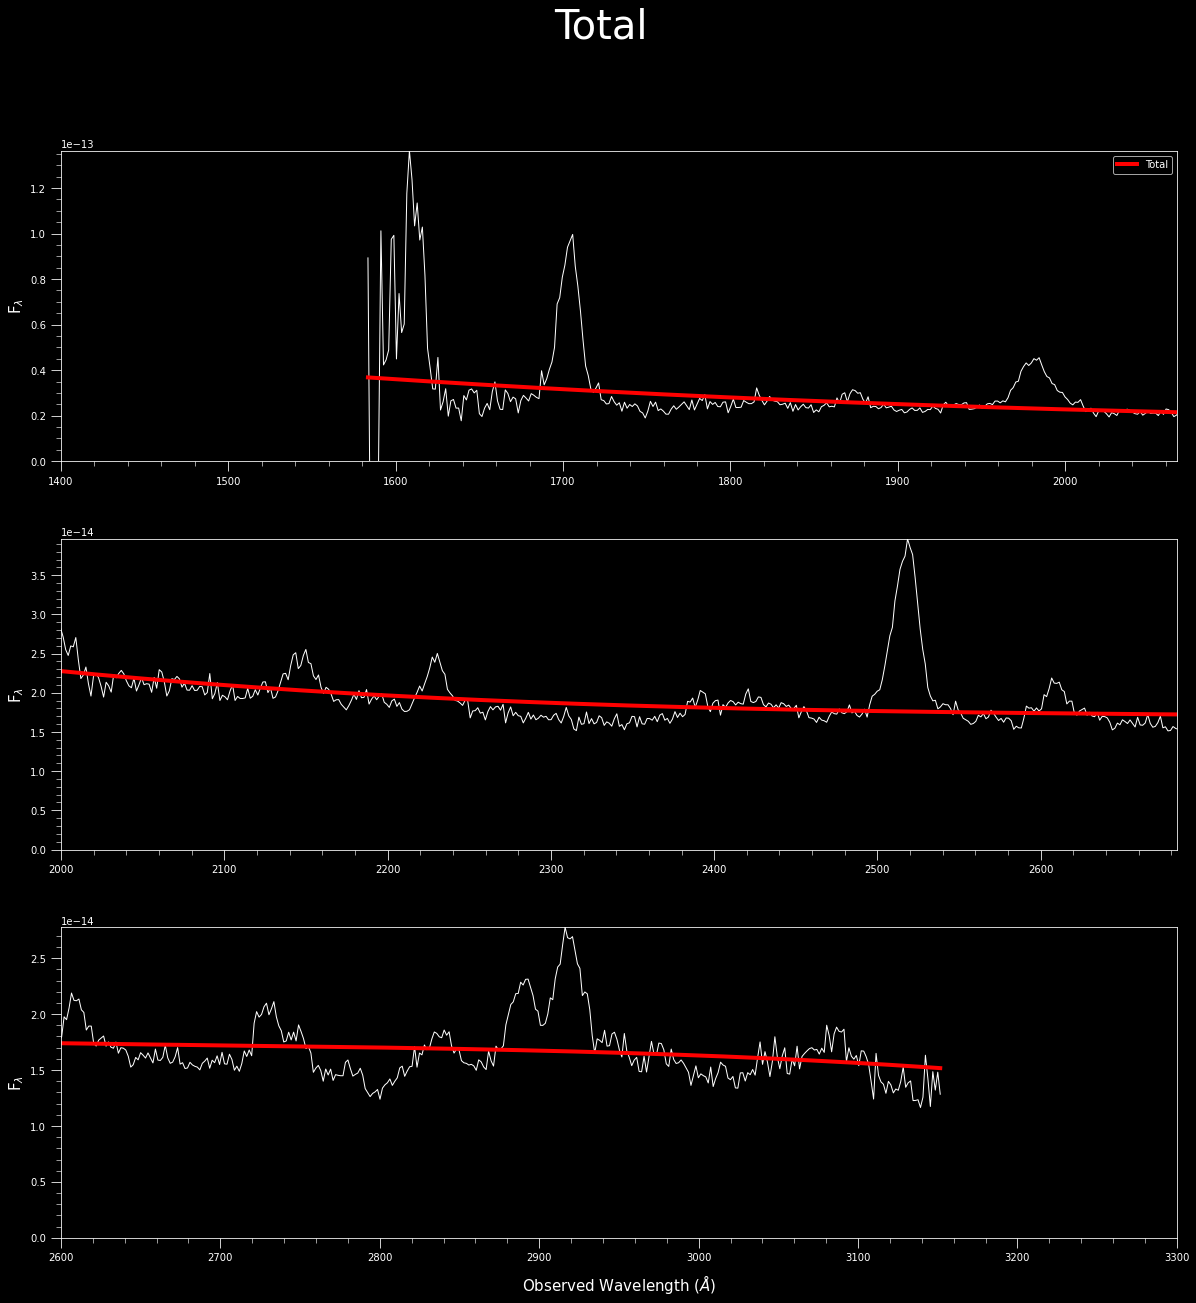

In [16]:
%matplotlib inline
q3da(initproc)

Plots in an external, interactive window:

In [ ]:
%matplotlib
q3da(initproc)